## Importing Libraries


In [4]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from tensorflow.keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import cv2
import os


## Data Preperation
 
1.   Load all training and testing data

2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images with devide by 255

5.   One Hot Encoding on the labels

6.   Dividing the dataset into Training and Validation sets





In [5]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


datasets = ["datasets/kaggle/processed/", "datasets/brain_tumor_collection/processed/" , "datasets/MRI-Images-of-Brain-Tumor/processed/"]
folders = ["train", "test", "val"]

for dataset in datasets:
    for folder in folders:
        path = os.path.join(dataset, folder)
        if not os.path.exists(path):
            continue

        for label in labels:
            fullPath = os.path.join(path, label)
            for file in tqdm(os.listdir(fullPath)):
                imagePath = os.path.join(fullPath, file)
                image = cv2.imread(imagePath,0)
                image = cv2.bilateralFilter(image, 2, 50, 50)
                image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
                image = cv2.resize(image, (image_size, image_size))
                cv2.imwrite(imagePath, image)
        

# for dataset in datasets:
#     path = os.path.join(dataset, "test")
#     if not os.path.exists(path):
#         continue

#     for label in labels:
#         fullPath = os.path.join(path, label)
#         for file in tqdm(os.listdir(fullPath)):
#             image = cv2.imread(os.path.join(fullPath, file),0) # load images in gray.
#             image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
#             image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
#             image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
            
#             x_test.append(image)
#             y_test.append(labels.index(label))


In [50]:
base_dir = "datasets/combined/test"
for i in range(0, len(x_test)):
    img = x_test[i]
    label = y_test[i]
    cv2.imwrite(os.path.join(base_dir, labels[label], str(i) + ".jpg"), img)


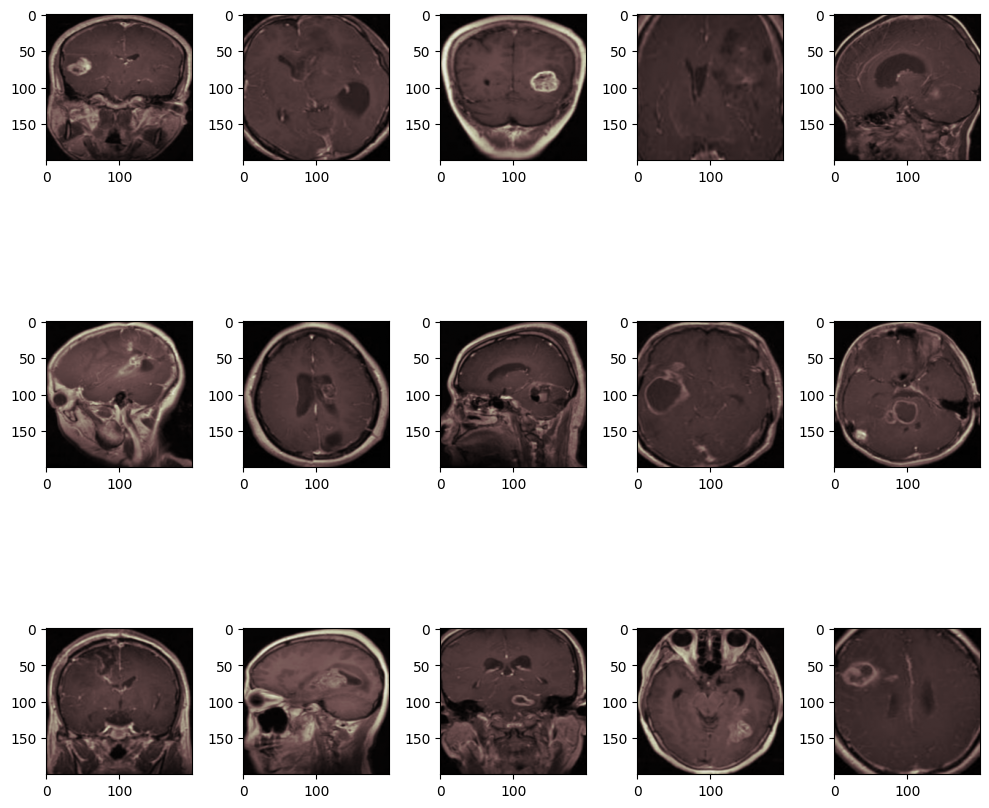

In [13]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [14]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(574, 200, 200, 3)


## Data Augmentation
In order to make the most of our few training examples, we will **augment** them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent **overfitting** and helps the model generalize better.

In [15]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [51]:
train_dir = "datasets/combined/train"
test_dir = "datasets/combined/test"

def clean_dir(base_dir):
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            if img is None or img.shape[0] is None or img.shape[1] is None:
                os.remove(file_path)

clean_dir(train_dir)
clean_dir(test_dir)

In [52]:
# base_dir = "datasets/combined/"
# train_dir = os.path.join(base_dir, "train")
# val_dir = os.path.join(base_dir, "val")

# for label in labels:
#     label_dir = os.path.join(train_dir, label)
#     files = os.listdir(label_dir)
#     val_files = files[:int(len(files) * 0.15)]
#     for file in val_files:
#         os.rename(os.path.join(label_dir, file), os.path.join(val_dir, label, file))

## Pre-trained Model
Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.


In this project, I'll be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




**Note**

Setting `include_top` to `False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training



In [47]:
base_dir = "datasets/combined/"
train_dir = os.path.join(base_dir, "train")
dest_dir = os.path.join(base_dir, "val")

for label in labels:
    full_path = os.path.join(train_dir, label)
    files = os.listdir(full_path)
    numOfFiles = len(files)
    perc = int(numOfFiles * 0.15)
    for i in range(perc):
        file = files[i]
        os.rename(os.path.join(full_path, file), os.path.join(test_dir, label, file))

In [8]:
train_dir = "datasets/combined/train"
test_dir = "datasets/combined/test"
val_dir = "datasets/combined/val"
image_size = 200

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

val_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

batch_size = 10

train_generator = train_gen.flow_from_directory(train_dir, target_size=(image_size,image_size), batch_size=batch_size, class_mode='categorical')
val_generator = val_gen.flow_from_directory(val_dir, target_size=(image_size,image_size), batch_size=batch_size, class_mode='categorical')
test_generator = test_gen.flow_from_directory(test_dir, target_size=(image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 11404 images belonging to 4 classes.
Found 2010 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.


2024-02-18 10:32:37.776992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 10:32:37.777264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/disuqi/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-02-18 10:32:37.777347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/disuqi/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-02-18 10:32:37.777380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could n

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [10]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))

    # Learning rate scheduler
    def lr_schedule(epoch):
        return 1e-3 * np.power(0.9, epoch // 10)

    model.compile(optimizer=Adam(learning_rate=lr_schedule(0)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
model = build_model()

In [5]:
from keras.applications import ResNet50Í

net = ResNet50(
    weights='imagenet',
     include_top=False,
     input_shape=(image_size,image_size,3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

## Training
**callback** -> set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**LambdaCallback** ->  will log the confusion matrix on every epoch.

**ModelCheckpoint** -> callback to save the Keras model or model weights at some frequency.

**EarlyStopping** -> stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau** -> reduce learning rate when a metric has stopped improving.

In [15]:
EPOCHS=100
  
ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights=True,verbose = 1)
RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL]

history = model.fit(train_generator, validation_data =val_generator, epochs = EPOCHS, callbacks = callbacks)

Epoch 1/100


1141/1141 [==============================] - 113s 99ms/step - loss: 0.4002 - accuracy: 0.8443 - val_loss: 0.3502 - val_accuracy: 0.8552 - lr: 3.0000e-04
Epoch 2/100
1141/1141 [==============================] - 111s 97ms/step - loss: 0.3715 - accuracy: 0.8534 - val_loss: 0.4225 - val_accuracy: 0.8473 - lr: 3.0000e-04
Epoch 3/100
1141/1141 [==============================] - 113s 99ms/step - loss: 0.3797 - accuracy: 0.8466 - val_loss: 0.3192 - val_accuracy: 0.8697 - lr: 3.0000e-04
Epoch 4/100
1141/1141 [==============================] - 117s 102ms/step - loss: 0.3629 - accuracy: 0.8598 - val_loss: 0.3395 - val_accuracy: 0.8647 - lr: 3.0000e-04
Epoch 5/100
1141/1141 [==============================] - 114s 100ms/step - loss: 0.3469 - accuracy: 0.8608 - val_loss: 0.3033 - val_accuracy: 0.8731 - lr: 3.0000e-04
Epoch 6/100
1141/1141 [==============================] - 114s 100ms/step - loss: 0.3622 - accuracy: 0.8565 - val_loss: 0.2904 - val_accuracy: 0.8891 - lr: 3.0000e-04
Epoch 7/100
1141/11

In [11]:
model.save("models/combined_categorical.h5")

## Learning curves

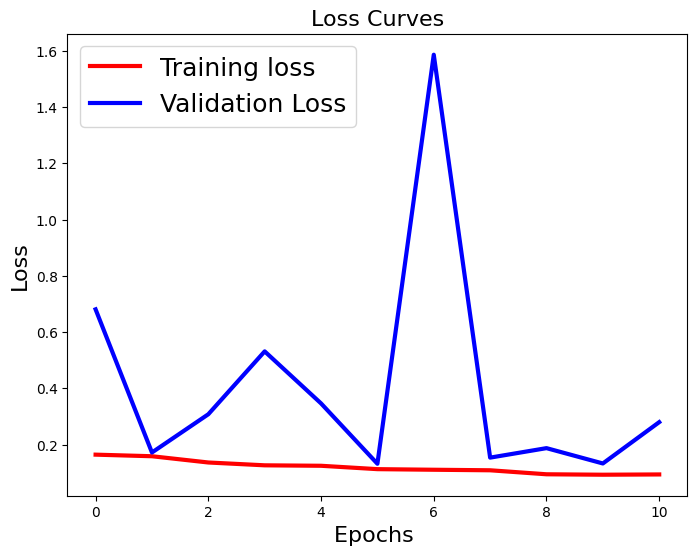

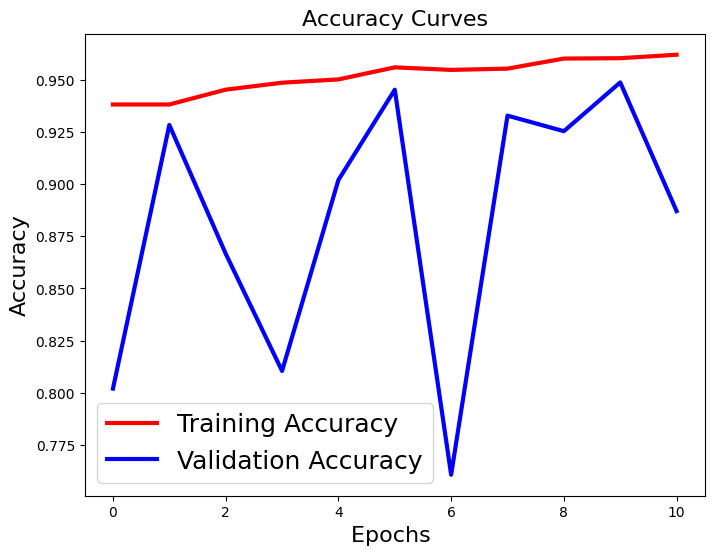

In [8]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       294
           1       0.98      0.97      0.98       303
           2       1.00      1.00      1.00       403
           3       0.99      0.99      0.99       294

    accuracy                           0.99      1294
   macro avg       0.99      0.99      0.99      1294
weighted avg       0.99      0.99      0.99      1294



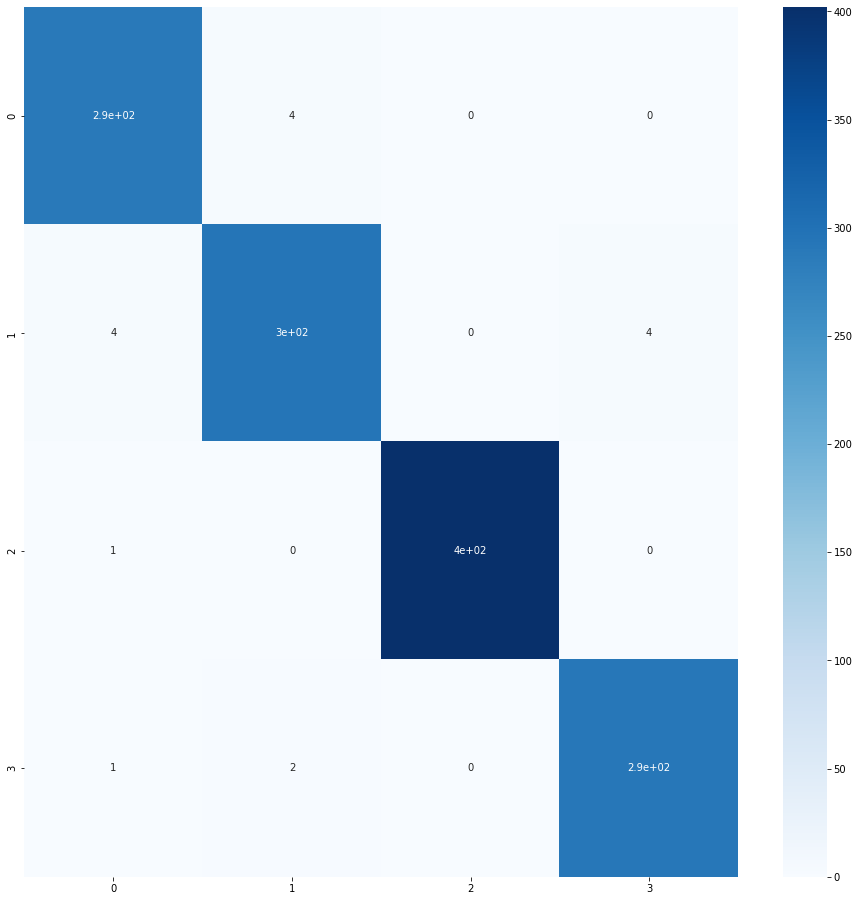

In [ ]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [1]:
from tensorflow.keras.models import load_model
model = load_model("models/combined_categorical.h5")

2024-02-16 16:06:45.433260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 16:06:45.433445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-16 16:06:45.433502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-02-16 16:06:45.433534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-02-16 16:06:45.433577: W tensorf

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 198, 198, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 97, 97, 64)       256       
 hNormalization)                                                 
                                                      

In [28]:
train_generator_2 = test_gen.flow_from_directory("datasets/brain_tumor_collection/processed/train", target_size=(image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 2870 images belonging to 4 classes.


In [9]:
loss,acc=model.evaluate(train_generator)

2024-02-18 18:28:13.572477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-18 18:28:14.164314: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-18 18:28:15.166511: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1141/1141 [==============================] - 77s 64ms/step - loss: 0.0320 - accuracy: 0.9876


In [17]:
def reshape_dataset(dataset, target_shape=(200, 200)):
    reshaped_images = []

    for img in dataset:
        # Resize the image
        resized_img = img.resize(target_shape)
        
        # Append the resized image to the list
        reshaped_images.append(resized_img)

    return reshaped_images

In [18]:
from datasets import load_from_disk
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_dir = os.getcwd() + '/datasets/brain_tumor_collection/'

data = load_from_disk(base_dir)

train_images = data['train']['image']
train_labels = data['train']['label']

test_images = data['test']['image']
test_labels = data['test']['label']

train_images = reshape_dataset(train_images)
test_images = reshape_dataset(test_images)

import numpy as np
from tensorflow.keras.utils import to_categorical

combined_data = list(zip(train_images, train_labels))

# Shuffle the combined data
np.random.shuffle(combined_data)

# Unzip the shuffled data
shuffled_images, shuffled_labels = zip(*combined_data)

# Calculate the index to split the training set for validation
split_index = int(len(shuffled_images) * 0.8)  # Adjust the split percentage as needed

# Split the shuffled data into training and validation sets
val_images, val_labels = shuffled_images[split_index:], shuffled_labels[split_index:]
train_images, train_labels = shuffled_images[:split_index], shuffled_labels[:split_index]

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_images = np.stack(train_images)

train_generator = train_datagen.flow(
    x=train_images,
    y=to_categorical(train_labels, num_classes=4),
    batch_size=32,
)

test_images = np.stack(test_images)

test_generator = test_datagen.flow(
    x=test_images,
    y=to_categorical(test_labels, num_classes=4),
    batch_size=32,
)

val_images = np.stack(val_images)

val_generator = test_datagen.flow(
    x=val_images,
    y=to_categorical(val_labels, num_classes=4),
    batch_size=32,
)

: 

In [ ]:
model.evaluate(train_generator)

In [ ]:
from datasets import load_from_disk
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

second_base_dir = os.getcwd() + '/datasets/MRI-Images-of-Brain-Tumor/'

second_data = load_from_disk(second_base_dir)

second_train_images = second_data['train']['image']
second_train_labels = second_data['train']['label']

second_test_images = second_data['test']['image']
second_test_labels = second_data['test']['label']

second_val_images = second_data['validation']['image']
second_val_labels = second_data['validation']['label']

second_train_images = reshape_dataset(second_train_images)
second_test_images = reshape_dataset(second_test_images)
second_val_images = reshape_dataset(second_val_images)

import numpy as np
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize

second_train_datagen = ImageDataGenerator(rescale=1./255)
second_test_datagen = ImageDataGenerator(rescale=1./255)

second_train_images = np.stack(second_train_images)

# Generate the image data
second_train_generator = second_train_datagen.flow(
    x=second_train_images,
    y=to_categorical(second_train_labels, num_classes=4),
    batch_size=32,
)

second_test_images = np.stack(second_test_images)

second_test_generator = second_test_datagen.flow(
    x=second_test_images,
    y=to_categorical(second_test_labels, num_classes=4),
    batch_size=32,
)

second_val_images = np.stack(second_val_images)

second_val_generator = test_datagen.flow(
    x=second_val_images,
    y=to_categorical(second_val_labels, num_classes=4),
    batch_size=32,
)

In [ ]:
model.evaluate(second_train_generator)

In [1]:
from tensorflow.keras.models import load_model

model = load_model("models/combined_categorical.h5")

2024-02-18 18:26:09.403033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 18:26:09.439715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 18:26:09.439745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 18:26:09.440622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 18:26:09.446310: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "models/converted_categorical")